紅眼航班資料處理

In [1]:
import pandas as pd
from datetime import datetime

# 載入資料並刪除價格歷史為空的列
data = pd.read_csv('/Users/yuchingchen/Documents/專題/data/history/tokyo_history_1020.csv')
data = data[['航班代碼', '出發時間', '價格歷史']].dropna(subset=['價格歷史'])

# 設定參考日期
reference_date = datetime.strptime("10/20", "%m/%d")


# 判斷是否為紅眼航班的函數（直接檢查出發時間文字）
def is_red_eye_flight(departure_time):
    if "凌晨" in departure_time:
        try:
            # 提取時間
            time_obj = datetime.strptime(departure_time.replace("凌晨", "").replace("。", ""), "%I:%M")
            # 若時間介於 0 到 6 點之間，則為紅眼航班
            return 1 if 0 <= time_obj.hour < 6 else 0
        except ValueError:
            return 0
    return 0

# 新增紅眼航班欄位
data['紅眼航班'] = data['出發時間'].apply(is_red_eye_flight)

# 處理價格歷史，將日期轉換為剩餘天數，並計算歷史價格平均和最低價格
def process_price_history(history):
    entries = history.split(", ")
    remaining_days_with_prices = []
    prices = []
    
    for entry in entries:
        if "天前" in entry:
            days_ago = int(entry.split("天前")[0].strip())
            remaining_days = days_ago
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif "今天" in entry:
            remaining_days = 0
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif " - " in entry:
            date_str, price_str = entry.split(" - ")
            date_obj = datetime.strptime(date_str, "%m/%d")
            remaining_days = (reference_date - date_obj).days
            price = int(price_str.replace("$", "").replace(",", ""))
        else:
            continue

        remaining_days_with_prices.append((remaining_days, f"${price:,}"))
        prices.append((price, remaining_days))
    
    avg_price = round(sum([p[0] for p in prices]) / len(prices)) if prices else None
    
    if prices:
        min_price = min([p[0] for p in prices])
        min_days_left = [days for price, days in prices if price == min_price]
        min_price_formatted = f"${min_price:,}"
    else:
        min_price_formatted, min_days_left = None, None
    
    return remaining_days_with_prices, avg_price, min_price_formatted, min_days_left

# 對每一行的價格歷史應用處理函數並新增歷史價格平均、最低價格及其所有剩餘天數欄位
data[['剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數']] = data['價格歷史'].apply(lambda x: pd.Series(process_price_history(x)))

# 刪除不需要的原始價格歷史欄位
data = data[['航班代碼', '出發時間', '剩餘天數及價格', '歷史價格平均', '最低價格', '最低價格剩餘天數', '紅眼航班']]

# 顯示結果
print(data.head())

# 顯示紅眼航班 = 1 的前五筆資料
print(data[data['紅眼航班'] == 1].head())

     航班代碼      出發時間                                            剩餘天數及價格  \
0  IT 202   下午1:30。  [(62, $5,099), (61, $5,099), (60, $5,099), (59...   
1  SL 394  中午12:10。  [(59, $6,159), (58, $6,159), (57, $6,159), (56...   
2  TR 874   下午2:50。  [(44, $4,188), (43, $4,188), (42, $4,188), (41...   
3   GK 14  中午12:50。  [(50, $5,889), (49, $5,889), (48, $5,889), (47...   
4  IT 700   下午2:45。  [(58, $3,299), (57, $3,299), (56, $3,699), (55...   

   歷史價格平均    最低價格                                           最低價格剩餘天數  紅眼航班  
0  4842.0  $3,699                                                [4]     0  
1  5688.0  $4,495                                   [10, 9, 8, 7, 6]     0  
2  4202.0  $3,588                           [23, 22, 21, 20, 19, 18]     0  
3  4276.0  $3,589  [39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 2...     0  
4  4079.0  $3,299                                           [58, 57]     0  
      航班代碼      出發時間                                            剩餘天數及價格  \
5    GK 12   凌晨2:2

平均價格跟最低價格（按是否紅眼航班分類）

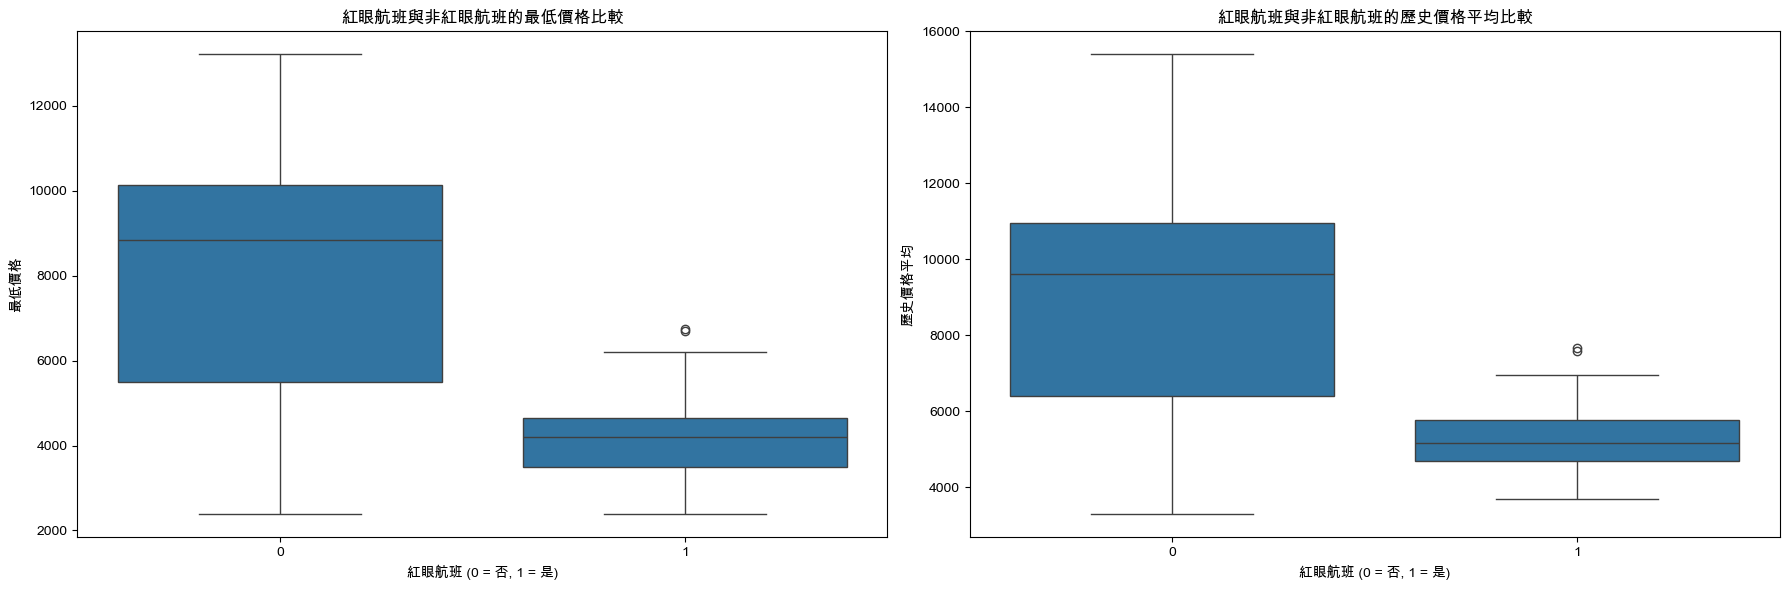

In [12]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料並刪除價格歷史為空的列
data = pd.read_csv('/Users/yuchingchen/Documents/專題/data/history/tokyo_history_1020.csv')
data = data[['航班代碼', '出發時間', '價格歷史']].dropna(subset=['價格歷史'])

# 設定參考日期
reference_date = datetime.strptime("10/20", "%m/%d")

# 判斷是否為紅眼航班的函數
def is_red_eye_flight(departure_time):
    if "凌晨" in departure_time:
        try:
            # 提取時間
            time_obj = datetime.strptime(departure_time.replace("凌晨", "").replace("。", ""), "%I:%M")
            # 若時間介於 0 到 6 點之間，則為紅眼航班
            return 1 if 0 <= time_obj.hour < 6 else 0
        except ValueError:
            return 0
    return 0

# 新增紅眼航班欄位
data['紅眼航班'] = data['出發時間'].apply(is_red_eye_flight)

# 處理價格歷史，計算最低價格和平均價格
def process_price_history(history):
    entries = history.split(", ")
    prices = []
    
    for entry in entries:
        if "天前" in entry:
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif "今天" in entry:
            price = int(entry.split(" - ")[-1].replace("$", "").replace(",", ""))
        elif " - " in entry:
            price_str = entry.split(" - ")[1]
            price = int(price_str.replace("$", "").replace(",", ""))
        else:
            continue
        prices.append(price)
    
    avg_price = round(sum(prices) / len(prices)) if prices else None
    min_price = min(prices) if prices else None
    return avg_price, min_price

# 新增歷史價格平均和最低價格欄位
data[['歷史價格平均', '最低價格']] = data['價格歷史'].apply(lambda x: pd.Series(process_price_history(x)))

# 去除航班代碼或最低價格為空的列
plot_data = data.dropna(subset=['航班代碼', '最低價格'])

# 創建子圖，分別繪製最低價格和歷史價格平均的盒狀圖
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 繪製最低價格的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='最低價格', ax=axes[0])
axes[0].set_title('紅眼航班與非紅眼航班的最低價格比較')
axes[0].set_xlabel('紅眼航班 (0 = 否, 1 = 是)')
axes[0].set_ylabel('最低價格')

# 繪製歷史價格平均的盒狀圖
sns.boxplot(data=plot_data, x='紅眼航班', y='歷史價格平均', ax=axes[1])
axes[1].set_title('紅眼航班與非紅眼航班的歷史價格平均比較')
axes[1].set_xlabel('紅眼航班 (0 = 否, 1 = 是)')
axes[1].set_ylabel('歷史價格平均')

plt.tight_layout()
plt.show()